In [2]:
%matplotlib inline
from pycocotools.coco import COCO # has to be installed manually from https://github.com/cocodataset/cocoapi
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
#set path to coco data
dataDir=Path('C:/projects/mealsuggestion/coco/images')
annTrainFile=Path('C:/projects/mealsuggestion/coco/annotations/instances_train2017.json')
annValFile=Path('C:/projects/mealsuggestion/coco/annotations/instances_val2017.json')
print(dataDir,annTrainFile,annValFile)

C:\projects\mealsuggestion\coco\images C:\projects\mealsuggestion\coco\annotations\instances_train2017.json C:\projects\mealsuggestion\coco\annotations\instances_val2017.json


In [4]:
# initialize COCO api for instance annotations
import os
print(os.getcwd())
coco_train =COCO(str(annTrainFile))
coco_val =COCO(str(annValFile))

C:\projects\mealsuggestion
loading annotations into memory...
Done (t=24.92s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco_train.loadCats(coco_train.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
kitchen animal person food accessory appliance furniture sports outdoor electronic vehicle indoor


In [6]:
# get all images containing food
catIds = coco_train.getCatIds(catNms=[ 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake']);
from itertools import chain
imgIds_train = set(chain.from_iterable(coco_train.getImgIds(catIds=catid) for catid in catIds))
imgIds_val = set(chain.from_iterable(coco_val.getImgIds(catIds=catid) for catid in catIds))



# example
img = coco_train.loadImgs(imgIds_train)[0]
print(len(imgIds_train))
print(len(imgIds_val))
print(img)

16255
708
{'license': 2, 'file_name': '000000262145.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000262145.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-20 02:07:55', 'flickr_url': 'http://farm8.staticflickr.com/7187/6967031859_5f08387bde_z.jpg', 'id': 262145}


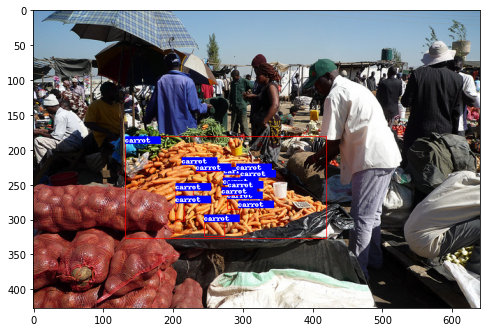

In [7]:
# load and display example annotated image
from PIL import Image, ImageDraw
import requests
from io import BytesIO

def draw_img(img):
    response = requests.get(img['coco_url'])
    im = Image.open(BytesIO(response.content))
    draw = ImageDraw.Draw(im)


    annIds = coco_train.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_train.loadAnns(annIds)
    for i in anns:
        [x,y,w,h] = i['bbox']
        draw.rectangle(((int(x), int(y)), (int(x+w), int(y+h))), outline="red")
        draw.rectangle(((int(x), int(y)), (int(x+50), int(y+10))), fill="blue")
        draw.text((x, y), coco_train.loadCats(ids=[i['category_id']])[0]['name'], fill=(255,255,255,128))
    plt.imshow(im)
    plt.show()
    

draw_img(img)

In [10]:
#functions for creating darknet label

def get_new_id_of(class_name):
    catNms = ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake']
    return catNms.index(class_name)

def get_old_id_of(class_name):
    catNms=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush']
    return catNms.index(class_name)

def create_darknet_label(x_size, y_size, x, y, width, height, class_name, coco=False):
    # Each row is class x_center y_center width height format.
    x_center = (x+(width/2.0))/x_size
    y_center = y_center = (y+(height/2.0))/y_size
    if coco:
        classid = get_old_id_of(class_name)
    else:
        classid = get_new_id_of(class_name)
    return classid, x_center, y_center, 1.0*width/x_size, 1.0*height/y_size 

# examples
annIds = coco_train.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_train.loadAnns(annIds)

for i in anns:
    [x,y,w,h] = i['bbox']
    print(create_darknet_label(img['width'],  img['height'], w, y, w, h, coco_train.loadCats(ids=[i['category_id']])[0]['name']))

#banane
print(get_old_id_of("banana"))
print(get_new_id_of("banana"))

46
0


In [28]:
# customize folder as needed

import os
path = "C:\\projects\\mealsuggestion\\food" # for model with 10 food catgories
path_coco = "C:\\projects\\mealsuggestion\\food_coco" # for original with 40 catgories
img_train_path = os.path.join(path,"images\\train")
img_val_path = os.path.join(path,"images\\val")
labels_train_path = os.path.join(path,"labels\\train")
labels_val_path = os.path.join(path,"labels\\val")
labels_coco_train_path = os.path.join(path_coco,"labels\\train")
labels_coco_val_path = os.path.join(path_coco,"labels\\val")

if not os.path.exists(img_train_path):
    os.makedirs(img_train_path)
if not os.path.exists(img_val_path):
    os.makedirs(img_val_path)
if not os.path.exists(labels_train_path):
    os.makedirs(labels_train_path)
if not os.path.exists(labels_val_path):
    os.makedirs(labels_val_path)
if not os.path.exists(labels_coco_train_path):
    os.makedirs(labels_coco_train_path)
if not os.path.exists(labels_coco_val_path):
    os.makedirs(labels_coco_val_path)

    
#create symlink to folder of images 
if not os.path.exists(os.path.join(path_coco,"images")):    # does not work on windows
    try:
        os.symlink(os.path.join(path,"images"), os.path.join(path_coco,"images"))
    except OSError:
        ! mklink /J {os.path.join(path_coco,"images")} {os.path.join(path,"images")}

Junction created for C:\projects\mealsuggestion\food_coco\images <<===>> C:\projects\mealsuggestion\food\images


In [29]:
import sklearn.model_selection
import wget
from pathlib import Path

def lookup_food_data(coco, imgIds, is_train):
    imgs = coco.loadImgs(imgIds)
    annIds = coco.getAnnIds(imgIds=imgIds, catIds=catIds)
    annos = coco.loadAnns(annIds)
    images_to_load = [] # [tuple(origin, destination)]
    
    for img in imgs:
        img_anno = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
        anns = coco.loadAnns(img_anno)
        labels = []
        labels_coco = []
        
        
        for ann in anns:
            x,y,w,h = ann['bbox']
            x_size = img['width']
            y_size = img['height']
            anno_class = coco.loadCats(ids=[ann['category_id']])[0]['name']
            label = create_darknet_label(x_size,  y_size, x, y, w, h, anno_class)
            label_coco = create_darknet_label(x_size,  y_size, x, y, w, h, anno_class, coco=True)
            labels.append(" ".join(str(i) for i in label))
            labels_coco.append(" ".join(str(i) for i in label_coco))

        basename = Path(img['coco_url']).name
        stem = Path(img['coco_url']).stem
        
        if is_train:
            image_path = Path(os.path.join(img_train_path, basename))
            label_path = Path(os.path.join(labels_train_path, stem+".txt"))
            label_coco_path = Path(os.path.join(labels_coco_train_path, stem+".txt"))
        else:
            image_path = Path(os.path.join(img_val_path, basename))
            label_path = Path(os.path.join(labels_val_path, stem+".txt"))
            label_coco_path = Path(os.path.join(labels_coco_val_path, stem+".txt"))

        images_to_load.append((img['coco_url'],str(image_path))) # image location for later download

        with open(label_path, "w") as f: # create label for 10 cats
            f.write("\n".join(labels))
        with open(label_coco_path, "w") as f: # create label for 40 cats
            f.write("\n".join(labels_coco)) 
    
    return images_to_load
                              
images_to_load_train = lookup_food_data(coco_train, imgIds_train, True)
images_to_load_val = lookup_food_data(coco_val, imgIds_val, False)
                              
print(len(images_to_load_val), images_to_load_val[:10])

708 [('http://images.cocodataset.org/val2017/000000577539.jpg', 'C:\\projects\\mealsuggestion\\food\\images\\val\\000000577539.jpg'), ('http://images.cocodataset.org/val2017/000000241668.jpg', 'C:\\projects\\mealsuggestion\\food\\images\\val\\000000241668.jpg'), ('http://images.cocodataset.org/val2017/000000385029.jpg', 'C:\\projects\\mealsuggestion\\food\\images\\val\\000000385029.jpg'), ('http://images.cocodataset.org/val2017/000000311303.jpg', 'C:\\projects\\mealsuggestion\\food\\images\\val\\000000311303.jpg'), ('http://images.cocodataset.org/val2017/000000047112.jpg', 'C:\\projects\\mealsuggestion\\food\\images\\val\\000000047112.jpg'), ('http://images.cocodataset.org/val2017/000000260105.jpg', 'C:\\projects\\mealsuggestion\\food\\images\\val\\000000260105.jpg'), ('http://images.cocodataset.org/val2017/000000575500.jpg', 'C:\\projects\\mealsuggestion\\food\\images\\val\\000000575500.jpg'), ('http://images.cocodataset.org/val2017/000000528399.jpg', 'C:\\projects\\mealsuggestion\\fo

In [27]:
import os
import requests
from multiprocessing.pool import ThreadPool
import tqdm

OVERWRITE = False

def url_response( obj ):
    do_load = OVERWRITE
    url, path = obj
    if not OVERWRITE:
        file = Path(path)
        if not file.is_file():
            do_load = True
    if do_load:
        r = requests.get(url, stream = True)
        with open(path, 'wb') as f:
            for ch in r:
                f.write(ch)
            
pool = ThreadPool(9)
for _ in tqdm.tqdm(pool.imap_unordered(url_response, images_to_load_train), total=len(images_to_load_train)):
    pass
for _ in tqdm.tqdm(pool.imap_unordered(url_response, images_to_load_val), total=len(images_to_load_val)):
    pass


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 708/708 [01:00<00:00, 11.78it/s]
